# <center>Лабораторная работа №3</center>
###### <center> Сокрытие данных в пространственной области неподвижных изображений на основе прямого расширения спектра</center>
<p>
<center>
_по курсу: "Стеганография"_
</center>
<center>
_Кривич Максим, Даниил Науменко, КБ-41_
</center>
<center>
_Харьков - 2017г._
</center>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.linalg import hadamard

In [2]:
img_tamplate = 'images/img{}.bmp'
steg_img_tamplate = 'images/stego{}.bmp'
text_file = 'text.txt'
eol = '$$'

In [3]:
def np_2_image(array):
    try:
        return Image.fromarray(array)
    except:
        return None

In [4]:
def image_2_np(image):
    try:
        return np.array(image)
    except:
        return None

In [5]:
def open_image_2_np(filename):
    return image_2_np(Image.open(filename))

In [6]:
def read_text(filename):
    with codecs.open(filename, encoding='ascii', mode='r') as f:
        return f.read().strip()

In [7]:
def str_2_bin(*args):
    return ''.join(bin(ord(x))[2:].zfill(8) for x in ''.join(args))

In [8]:
def bin_2_str(binary, length=8):
    bin_l = [binary[i:i+length] for i in range(0, len(binary), length)]
    return ''.join([chr(int(c, 2)) for c in bin_l])

In [9]:
def chunks(l, n, step=4):
    for i in range(0, len(l) - n + 1, step):
        yield l[i:i + n]

### Задание №1 - Реализация алгоритмов формирования ансамблей ортогональных дискретных сигналов Уолша-Адамара и алгоритмов кодирования информационных бит данных сложными дискретными сигналами

In [10]:
def my_hadamard(k, hmat):
    if 2 ** (k-1) == 1:
        return hmat
    else:
        return np.kron(hmat, my_hadamard(k - 1, hmat))

In [11]:
def transform_message(bin_array):
    bin_array[bin_array != 1] = -1
    return bin_array

In [12]:
def inverse_transform_message(array):
    array[array != 1] = 0
    return array

In [13]:
def get_sum(height, message, matrix, k=4, g=3):
    res = []
    for i in range(height):
        a = sum([g*message[k*i+j]*matrix[j+1] for j in range(k) if k*i+j < len(message)])
        if type(a) is int:
                break
        res.append(a)
    return res

In [14]:
%timeit my_hadamard(8, np.matrix([[1,1],[1,-1]]))

694 µs ± 100 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Задача №2 - Реализация алгоритмов сокрытия и извлечения данных в пространственной области изображений путем прямого расширения спектров с использованием ортогональных дискретных сигналов

In [15]:
def encode(image, message, matrix):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    result = np.copy(container)
    secret_message = str_2_bin(message, eol)
    l_sm = len(secret_message)
    if height < l_sm:
        raise ValueError('Message is to long for this image')
    
    secret_message = transform_message(np.array([int(i) for i in secret_message]))
    sums = get_sum(height,secret_message, matrix)

    for i in range(height):
        for j in range(width):
            if i < len(sums) and j < len(sums[i]):
                nr = result[i, j, 0] + sums[i][j]
                if nr > 255:
                    r = 255
                if nr < 0:
                     nr = 0
                result[i, j][0] = nr
    return np_2_image(result), sums

In [16]:
def decode(image, matrix, k=4):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    res = []
    
    for i in range(width):
        for j in range(k):
            a = np.array([p[0] for p in container[i]])[:256].dot(matrix[j+1])
            if a > 0:
                res.append(1)
            elif a <= 0:
                res.append(-1)
    res = np.array(res)
    res = bin_2_str(''.join(str(int(i)) for i in inverse_transform_message(res)))
    return res[:res.rfind(eol)]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


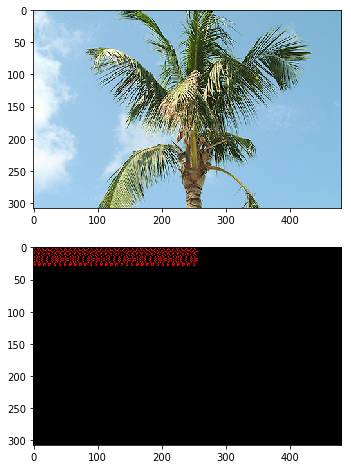

In [17]:
%time
matrix = hadamard(256)
stego_img, sums = encode(img_tamplate.format(2), 'Maxim Krivich', matrix)
stego_img.save(steg_img_tamplate.format(2))

f,ax = plt.subplots(2, figsize=(8, 8))
ax[0].imshow(stego_img)
ax[1].imshow(np_2_image(stego_img - open_image_2_np(img_tamplate.format(2))))
plt.show()

In [18]:
%timeit encode(img_tamplate.format(2), 'Maxim Krivich', matrix)

83.1 ms ± 8.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
for i in range(5):
    print(sums[0].dot(matrix[i]))

0
-768
768
-768
-768


In [20]:
print('PLAINTEXT: ' + decode(steg_img_tamplate.format(2), matrix))
%timeit decode(steg_img_tamplate.format(2), matrix)

PLAINTEXT: Maxim Krivich
310 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Задача №3 - Проведение экспериментальных исследований вероятностных свойств реализуемого метода, получение эмпирических зависимостей вероятности правильного извлечения данных и доли внесенных при этом погрешностей в контейнер-изображение

In [ ]:
%time

Posh_k = []
W_k = []

for i in range(1, 9):
    stego_img, sums =  encode(img_tamplate.format(2), 'Maxim Krivich', matrix,k=2**i, g=1)
    stego_img.save(steg_img_tamplate.format(3))